In [2]:
# Install Optuna for hyperparameter optimization
!pip install --quiet optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.2 MB/s eta 0:00:00


In [3]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

drive_basepath = '/content/drive/MyDrive/ML/Project'
!unzip -nq '{drive_basepath}/test_data_unlabeled.zip'
!unzip -nq '{drive_basepath}/train_data_unlabeled.zip'
!cp -n '{drive_basepath}/y_train.csv' .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
import re
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AlphaDropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import optuna
from optuna.integration import KerasPruningCallback
from optuna.integration import TFKerasPruningCallback
import zipfile
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import optuna.visualization as optvis

In [5]:
x_train_path = "train_data_unlabeled"
y_train_path = "y_train.csv"
x_test_path = "test_data_unlabeled"

In [6]:
# Function for loading test data and preprocessing
def load_train_data(images_path, csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Load images and preprocess
    images = []
    labels = []

    for _, row in df.iterrows():
        file = os.path.join(images_path, f"img_{row['id'] + 1}.png")
        if not os.path.exists(file):
            print(f"Image file {file} not found. Skipping.")
            continue

        try:
            # Open the image
            image = Image.open(file)

            # Convert to RGB
            image = image.convert('RGB')

            # Crop the image by 2 pixels from each side, which removes white border
            width, height = image.size
            left, upper, right, lower = 2, 2, width - 2, height - 2
            image = image.crop((left, upper, right, lower))

            # Resize to the actual amount of pixels
            image = image.resize((50, 44))

            # Normalize pixel values
            image = np.array(image).astype('float32') / 255.0

            images.append(image)
            labels.append(row['target'])

        except IOError as e:
            print(f"Error reading image {file}: {e}")
            continue

    images = np.array(images)
    labels = pd.get_dummies(labels)

    return images, labels

In [7]:
x_train, y_train = load_train_data(x_train_path, y_train_path)

In [8]:
# Check number of samples
print(f"Number of samples in x_train: {len(x_train)}")
print(f"Number of samples in y_train: {len(y_train)}")

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Number of samples in x_train: 16182
Number of samples in y_train: 16182


In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to be tuned
    conv2d_filter = trial.suggest_categorical('conv2d_filter', [32, 64, 128])
    dense_units = trial.suggest_categorical('dense_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.7)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Model creation using the suggested hyperparameters
    model = Sequential()
    model.add(Conv2D(conv2d_filter, (3, 3), activation='relu', input_shape=(44, 50, 3)))
    model.add(Conv2D(conv2d_filter, (3, 3), activation='relu'))
    model.add(Conv2D(conv2d_filter, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

    # KerasPruningCallback
    pruning_callback = KerasPruningCallback(trial, 'val_accuracy')

    # Fit the model
    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=25,  # Modify
        callbacks=[early_stopping, pruning_callback],
        validation_data=(x_val, y_val),
        verbose=0
    )

    # Evaluate the model on the validation set
    score = model.evaluate(x_val, y_val, verbose=1)
    return score[1]  # Return the accuracy

In [10]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25, timeout=600)

# Print the best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2024-04-21 16:29:30,765] A new study created in memory with name: no-name-47e1e5f0-a3fb-4204-a3c7-3a5722f729ef


102/102 [==============================] - 0s 4ms/step - loss: 0.1817 - accuracy: 0.9552


[I 2024-04-21 16:30:09,857] Trial 0 finished with value: 0.9552054405212402 and parameters: {'conv2d_filter': 64, 'dense_units': 512, 'dropout_rate': 0.33228581881870994, 'learning_rate': 0.00019074487441254404}. Best is trial 0 with value: 0.9552054405212402.


Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
102/102 [==============================] - 1s 4ms/step - loss: 0.1287 - accuracy: 0.9605


[I 2024-04-21 16:30:36,447] Trial 1 finished with value: 0.9604572057723999 and parameters: {'conv2d_filter': 128, 'dense_units': 512, 'dropout_rate': 0.2096348362843879, 'learning_rate': 0.00041541288503905673}. Best is trial 1 with value: 0.9604572057723999.


102/102 [==============================] - 0s 3ms/step - loss: 0.1186 - accuracy: 0.9685


[I 2024-04-21 16:31:13,985] Trial 2 finished with value: 0.9684893488883972 and parameters: {'conv2d_filter': 64, 'dense_units': 1024, 'dropout_rate': 0.17794891316659614, 'learning_rate': 0.00011166255394571236}. Best is trial 2 with value: 0.9684893488883972.


102/102 [==============================] - 0s 3ms/step - loss: 0.1088 - accuracy: 0.9663


[I 2024-04-21 16:31:46,793] Trial 3 finished with value: 0.9663268327713013 and parameters: {'conv2d_filter': 64, 'dense_units': 512, 'dropout_rate': 0.6793588845399342, 'learning_rate': 0.00014959354910493416}. Best is trial 2 with value: 0.9684893488883972.


Restoring model weights from the end of the best epoch: 15.
Epoch 20: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 0.9673


[I 2024-04-21 16:32:08,788] Trial 4 finished with value: 0.9672536253929138 and parameters: {'conv2d_filter': 32, 'dense_units': 512, 'dropout_rate': 0.2875341388127498, 'learning_rate': 0.0014886795250150403}. Best is trial 2 with value: 0.9684893488883972.


Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1325 - accuracy: 0.9586


[I 2024-04-21 16:32:35,872] Trial 5 finished with value: 0.9586036205291748 and parameters: {'conv2d_filter': 128, 'dense_units': 1024, 'dropout_rate': 0.09370183740595296, 'learning_rate': 0.0006346791930956626}. Best is trial 2 with value: 0.9684893488883972.
[I 2024-04-21 16:32:39,240] Trial 6 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:32:43,425] Trial 7 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:32:47,002] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:33:02,889] Trial 9 pruned. Trial was pruned at epoch 5.
[I 2024-04-21 16:33:06,933] Trial 10 pruned. Trial was pruned at epoch 0.


Restoring model weights from the end of the best epoch: 8.
Epoch 13: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9623


[I 2024-04-21 16:33:21,473] Trial 11 finished with value: 0.962310791015625 and parameters: {'conv2d_filter': 32, 'dense_units': 512, 'dropout_rate': 0.39785641441457764, 'learning_rate': 0.0011724912791449486}. Best is trial 2 with value: 0.9684893488883972.


Restoring model weights from the end of the best epoch: 13.
Epoch 18: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1168 - accuracy: 0.9713


[I 2024-04-21 16:33:42,229] Trial 12 finished with value: 0.9712696671485901 and parameters: {'conv2d_filter': 32, 'dense_units': 1024, 'dropout_rate': 0.34207120447039563, 'learning_rate': 0.0015152773006698575}. Best is trial 12 with value: 0.9712696671485901.
[I 2024-04-21 16:33:45,515] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:33:48,760] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:33:52,431] Trial 15 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:33:55,769] Trial 16 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:33:59,049] Trial 17 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:34:02,808] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:34:06,099] Trial 19 pruned. Trial was pruned at epoch 0.
[I 2024-04-21 16:34:09,408] Trial 20 pruned. Trial was pruned at epoch 0.


Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.9673


[I 2024-04-21 16:34:24,969] Trial 21 finished with value: 0.9672536253929138 and parameters: {'conv2d_filter': 32, 'dense_units': 512, 'dropout_rate': 0.27581355333074764, 'learning_rate': 0.0013750370221312972}. Best is trial 12 with value: 0.9712696671485901.
[I 2024-04-21 16:34:35,115] Trial 22 pruned. Trial was pruned at epoch 7.
[I 2024-04-21 16:34:38,367] Trial 23 pruned. Trial was pruned at epoch 0.


Restoring model weights from the end of the best epoch: 17.
Epoch 22: early stopping
102/102 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.9697


[I 2024-04-21 16:35:02,956] Trial 24 finished with value: 0.9697250723838806 and parameters: {'conv2d_filter': 32, 'dense_units': 1024, 'dropout_rate': 0.3862888365950206, 'learning_rate': 0.0013212523487001013}. Best is trial 12 with value: 0.9712696671485901.


Number of finished trials: 25
Best trial:
Value: 0.9712696671485901
Params: 
conv2d_filter: 32
dense_units: 1024
dropout_rate: 0.34207120447039563
learning_rate: 0.0015152773006698575


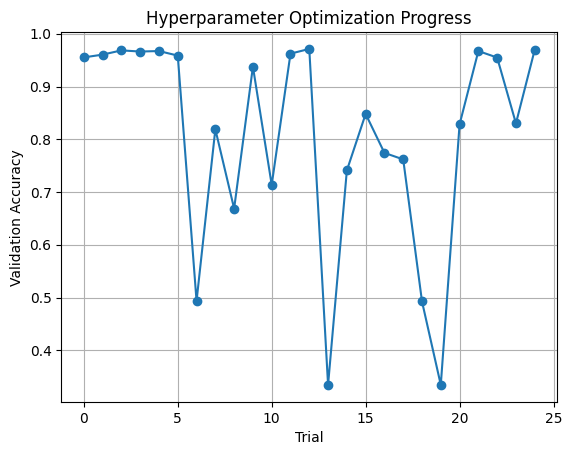

In [31]:
# Get the trials and their corresponding validation accuracies
trials = study.trials
val_accuracies = [trial.value for trial in trials]

# Plot the progress of hyperparameter optimization
plt.plot(val_accuracies, marker='o')
plt.xlabel('Trial')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Optimization Progress')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('hyperparameter_optimization.png')

plt.show()

In [12]:
# Retrieve the best hyperparameters from the Optuna study
best_conv2d_filter = study.best_params['conv2d_filter']
best_dense_units = study.best_params['dense_units']
best_dropout_rate = study.best_params['dropout_rate']
best_learning_rate = study.best_params['learning_rate']

# Create the final model using the best hyperparameters
model = Sequential()
model.add(Conv2D(best_conv2d_filter, (3, 3), activation='relu', input_shape=(44, 50, 3)))
model.add(Conv2D(best_conv2d_filter, (3, 3), activation='relu'))
model.add(Conv2D(best_conv2d_filter, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(best_dense_units, activation='relu'))
model.add(Dropout(best_dropout_rate))
model.add(Dense(4, activation='softmax'))

# Compile the final model
optimizer = Adam(learning_rate=best_learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
pruning_callback = KerasPruningCallback(trial, 'val_accuracy')

# Train the model on the entire training data
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,  # Adjust as needed
    callbacks=[early_stopping, pruning_callback],
    validation_data=(x_val, y_val),
    verbose=1
)

# Evaluate the final model on the validation set
final_score = model.evaluate(x_val, y_val, verbose=1)
print("Final validation accuracy:", final_score[1])

# Save the trained model
model.save('final_top_model.keras')

Epoch 1/50
203/203 [==============================] - 3s 7ms/step - loss: 0.6379 - accuracy: 0.7351 - val_loss: 0.3370 - val_accuracy: 0.8659
Epoch 2/50
203/203 [==============================] - 1s 6ms/step - loss: 0.2675 - accuracy: 0.8959 - val_loss: 0.2306 - val_accuracy: 0.9079
Epoch 3/50
203/203 [==============================] - 1s 6ms/step - loss: 0.1717 - accuracy: 0.9377 - val_loss: 0.1452 - val_accuracy: 0.9456
Epoch 4/50
203/203 [==============================] - 1s 6ms/step - loss: 0.1118 - accuracy: 0.9573 - val_loss: 0.1150 - val_accuracy: 0.9555
Epoch 5/50
203/203 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.9683 - val_loss: 0.1894 - val_accuracy: 0.9345
Epoch 6/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0586 - accuracy: 0.9782 - val_loss: 0.1135 - val_accuracy: 0.9617
Epoch 7/50
203/203 [==============================] - 1s 6ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.1121 - val_accuracy: 0.9657
Epoch 

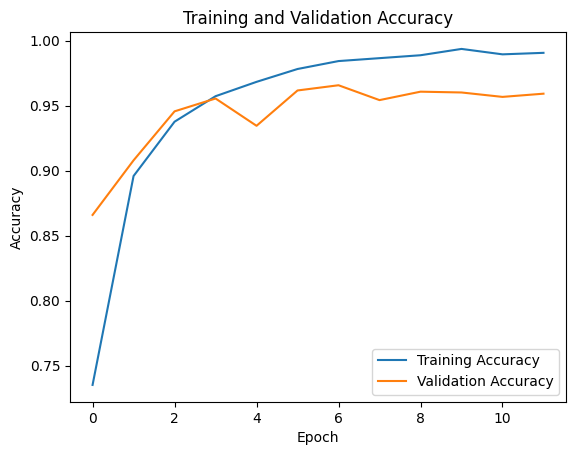

In [32]:
# Get the accuracy history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Save the plot as a PNG file
plt.savefig('accuracy_curves.png')

plt.show()

In [14]:
# Sorting function that sorts strings numerically when they contain numbers
def natural_sort_key(file_name):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', file_name)]

# Function to load and preprocess test data
def load_test_data(images_path):
    images = []

    # Load PNG images
    all_files = os.listdir(images_path)
    png_files = [file for file in all_files if file.endswith('.png')]

    # Sort images by filename using natural sort order
    file_names = sorted(png_files, key=natural_sort_key)

    for file_name in file_names:
        file = os.path.join(images_path, file_name)
        try:
            # Open the image
            image = Image.open(file)

            # Convert to RGB
            image = image.convert('RGB')

            # Crop the image by 2 pixels from each side, which removes white border
            width, height = image.size
            left, upper, right, lower = 2, 2, width - 2, height - 2
            image = image.crop((left, upper, right, lower))

            # Resize to actual amount of pixels
            image = image.resize((50, 44))

            # Normalize pixel values
            image = np.array(image).astype('float32') / 255.0

            images.append(image)

        except IOError as e:
            print(f"Error reading image {file}: {e}")
            continue

    images = np.array(images)
    return images

In [15]:
# Load model
saved_model = load_model('final_top_model.keras')

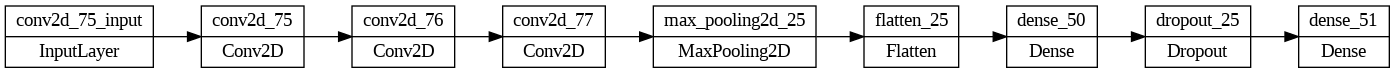

In [16]:
plot_model(saved_model, to_file='model_plot.png', show_shapes=False, show_layer_names=True, rankdir='LR')

In [17]:
# Load test data
x_test = load_test_data(x_test_path)

# Generate output predictions y_test from x_test
y_test_pred = saved_model.predict(x_test)

150/150 [==============================] - 0s 2ms/step


102/102 [==============================] - 0s 2ms/step


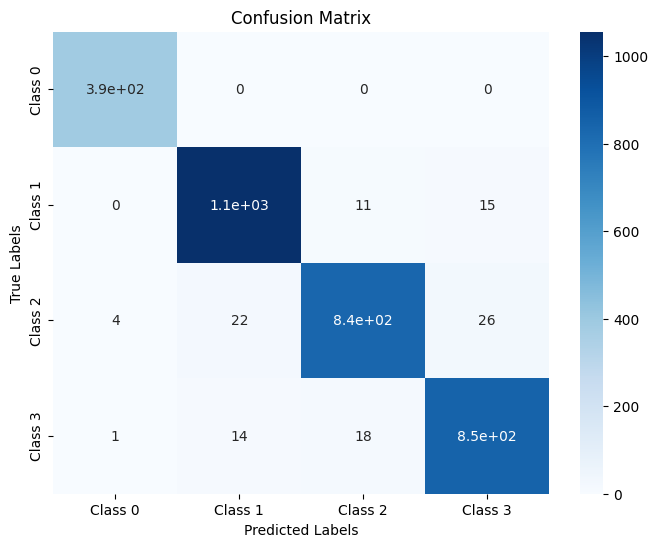

In [24]:
# Get the class labels
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Calculate the confusion matrix
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(saved_model.predict(x_val), axis=1)  # Use x_val for predictions
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

In [27]:
# Create a CSV file in the right format for Kaggle submission
y_test = pd.DataFrame({'id': range(len(y_test_labels)), 'target': y_test_labels})
y_test.to_csv('y_test.csv', index=False)

In [33]:
!cp confusion_matrix.png '{drive_basepath}'
!cp model_plot.png '{drive_basepath}'
!cp hyperparameter_optimization.png '{drive_basepath}'
!cp accuracy_curves.png '{drive_basepath}'
!cp y_test.csv '{drive_basepath}'
!cp final_top_model.keras '{drive_basepath}'